In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [41]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.fc1 = nn.Linear(784 + 1, 512)  # Add timestep t as input
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 784)

    def forward(self, x, t):
        # Concatenate time t to x
        t = t.unsqueeze(-1)  # make sure t has right shape
        x = torch.cat([x, t], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [42]:
def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha = torch.sqrt(alphas_cumprod[t]).view(-1, 1)
    sqrt_one_minus_alpha = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1)
    return sqrt_alpha * x_0 + sqrt_one_minus_alpha * noise, noise


In [43]:
T = 300  # total diffusion steps

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
# alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [45]:
model = SimpleUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

epochs = 25

for epoch in range(epochs):
    pbar = tqdm.tqdm(train_loader)
    for x, y in pbar:
        x = x.to(device)

        t = torch.randint(0, T, (x.size(0),), device=device).long()

        x_noisy, noise = forward_diffusion_sample(x, t)
        noise_pred = model(x_noisy, t.float() / T)

        loss = mse(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch} Loss {loss.item():.4f}")


Epoch 24 Loss 0.6146: 100%|██████████| 469/469 [00:06<00:00, 67.56it/s]


In [46]:
@torch.no_grad()
def sample(model, n_samples):
    model.eval()
    x = torch.randn(n_samples, 784).to(device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, device=device).float() / T
        pred_noise = model(x, t_tensor)

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]

        beta = betas[t]

        x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * pred_noise)

        if t > 0:
            x = x + torch.sqrt(beta) * torch.randn_like(x)

    x = x.view(n_samples, 1, 28, 28)
    return x


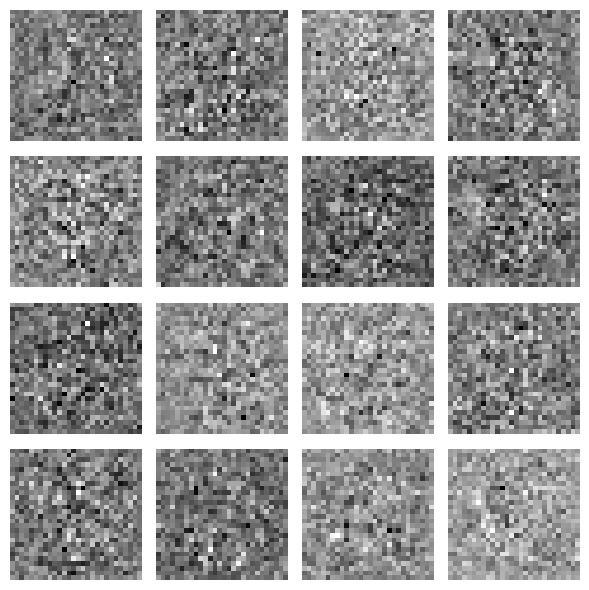

In [47]:
samples = sample(model, n_samples=16)

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


Epoch 0: Loss 0.6905
Epoch 1: Loss 0.5157
Epoch 2: Loss 0.4276
Epoch 3: Loss 0.4263
Epoch 4: Loss 0.3949
Epoch 5: Loss 0.3921
Epoch 6: Loss 0.4060
Epoch 7: Loss 0.3970
Epoch 8: Loss 0.4213
Epoch 9: Loss 0.4075


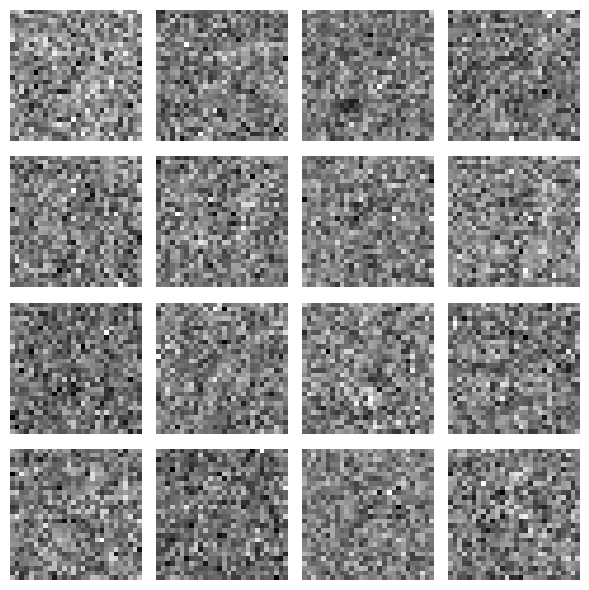

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 2000  # diffusion steps
image_size = 28
batch_size = 128
epochs = 10
lr = 1e-4


betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise, noise


class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        # emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -np.log(10000) / (half_dim))
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=t.device) * -np.log(10000) / (half_dim))
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
        return emb.to(t.device)


class SimpleDenoiser(nn.Module):
    def __init__(self, input_dim, time_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, 128),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            nn.Linear(input_dim + 128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        x = torch.cat([x, time_emb], dim=1)
        return self.net(x)

model = SimpleDenoiser(784, 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()


for epoch in range(epochs):
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_t, noise = forward_diffusion_sample(x, t, noise=None)
        noise_pred = model(x_t, t)
        loss = mse(noise, noise_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss {loss.item():.4f}")


@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x_t = torch.randn(n, 784).to(device)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        z = torch.randn_like(x_t) if t > 0 else 0
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        noise_pred = model(x_t, t_tensor)
        x_t = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        ) + torch.sqrt(beta_t) * z
    return x_t


samples = sample(model, n=16).cpu().view(-1, 28, 28)
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(samples[i*4 + j], cmap="gray")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


Epoch 1 | Loss: 0.0742: 100%|██████████| 938/938 [00:18<00:00, 50.63it/s]
Epoch 2 | Loss: 0.0637: 100%|██████████| 938/938 [00:16<00:00, 57.64it/s]
Epoch 3 | Loss: 0.0725: 100%|██████████| 938/938 [00:15<00:00, 60.53it/s]
Epoch 4 | Loss: 0.0670: 100%|██████████| 938/938 [00:16<00:00, 57.35it/s]
Epoch 5 | Loss: 0.0578: 100%|██████████| 938/938 [00:16<00:00, 55.75it/s]
Epoch 6 | Loss: 0.0590: 100%|██████████| 938/938 [00:15<00:00, 60.81it/s]
Epoch 7 | Loss: 0.0511: 100%|██████████| 938/938 [00:15<00:00, 59.14it/s]
Epoch 8 | Loss: 0.0428: 100%|██████████| 938/938 [00:16<00:00, 56.51it/s]
Epoch 9 | Loss: 0.0425: 100%|██████████| 938/938 [00:16<00:00, 55.92it/s]
Epoch 10 | Loss: 0.0476: 100%|██████████| 938/938 [00:16<00:00, 58.61it/s]


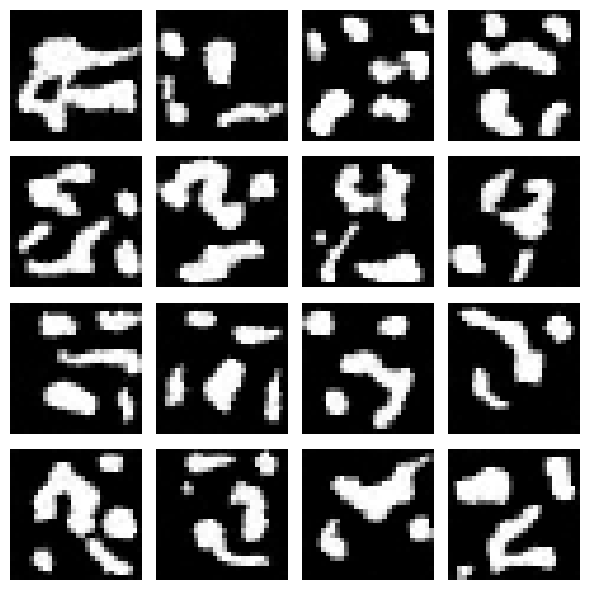

In [56]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Diffusion hyperparameters
T = 400
lr = 1e-4
batch_size = 128
epochs = 50

# Cosine noise schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alpha_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alpha_cumprod = alpha_cumprod / alpha_cumprod[0]
    betas = 1 - (alpha_cumprod[1:] / alpha_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Forward process
def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_ab = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_mab = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    return sqrt_ab * x_0 + sqrt_mab * noise, noise

# Time embedding (sinusoidal + MLP)
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -np.log(10000) / half_dim)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalTimeEmbedding(dim),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, t):
        return self.net(t)

# Simple U-Net
class UNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)

        self.down1 = nn.Conv2d(1, 32, 3, padding=1)
        self.down2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.mid = nn.Conv2d(64, 64, 3, padding=1)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.up_conv = nn.Conv2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)

        self.act = nn.ReLU()

    def forward(self, x, t):
        t_emb = self.time_mlp(t).view(t.shape[0], -1, 1, 1)
        x1 = self.act(self.down1(x))
        x2 = self.act(self.down2(self.pool(x1)))
        mid = self.act(self.mid(x2 + t_emb))
        x = self.up1(mid)
        x = torch.cat([x, x1], dim=1)
        x = self.act(self.up_conv(x))
        return self.out(x)

# Initialize model, optimizer, loss
model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    pbar = tqdm.tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t)
        pred = model(x_noisy, t)
        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# Sampling function
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        pred_noise = model(x, t_tensor)
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0
        x = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise
        ) + torch.sqrt(beta_t) * z
    return x

# Visualize samples
samples = sample(model, n=16).cpu().clamp(-1, 1)
samples = (samples + 1) / 2  # Rescale to [0, 1]
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(samples[i*4 + j].squeeze(), cmap="gray")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


Epoch 1 | Loss: 0.2528: 100%|██████████| 469/469 [00:11<00:00, 41.35it/s]
Epoch 2 | Loss: 0.1562: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]
Epoch 3 | Loss: 0.1477: 100%|██████████| 469/469 [00:10<00:00, 45.88it/s]
Epoch 4 | Loss: 0.1059: 100%|██████████| 469/469 [00:10<00:00, 45.48it/s]
Epoch 5 | Loss: 0.1312: 100%|██████████| 469/469 [00:10<00:00, 46.07it/s]
Epoch 6 | Loss: 0.1537: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s]
Epoch 7 | Loss: 0.1209: 100%|██████████| 469/469 [00:10<00:00, 45.45it/s]
Epoch 8 | Loss: 0.1157: 100%|██████████| 469/469 [00:10<00:00, 46.15it/s]
Epoch 9 | Loss: 0.0840: 100%|██████████| 469/469 [00:10<00:00, 45.80it/s]
Epoch 10 | Loss: 0.1088: 100%|██████████| 469/469 [00:10<00:00, 44.73it/s]
Epoch 11 | Loss: 0.1201: 100%|██████████| 469/469 [00:10<00:00, 45.24it/s]
Epoch 12 | Loss: 0.0966: 100%|██████████| 469/469 [00:10<00:00, 45.72it/s]
Epoch 13 | Loss: 0.1001: 100%|██████████| 469/469 [00:10<00:00, 45.09it/s]
Epoch 14 | Loss: 0.1100: 100%|████

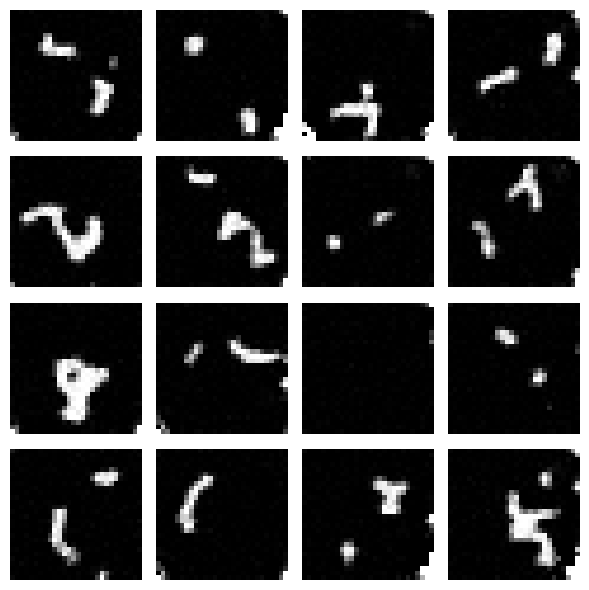

In [57]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Diffusion hyperparameters
T = 400
lr = 1e-4
batch_size = 128
epochs = 50

# Cosine noise schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alpha_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alpha_cumprod = alpha_cumprod / alpha_cumprod[0]
    betas = 1 - (alpha_cumprod[1:] / alpha_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Forward process
def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_ab = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_mab = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    return sqrt_ab * x_0 + sqrt_mab * noise, noise

# Time embedding (sinusoidal + MLP)
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -np.log(10000) / half_dim)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalTimeEmbedding(dim),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, t):
        return self.net(t)

# Simple U-Net
class UNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)

        self.down1 = nn.Conv2d(1, 32, 3, padding=1)
        self.down2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.mid = nn.Conv2d(64, 64, 3, padding=1)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.up_conv = nn.Conv2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)

        self.act = nn.ReLU()

    def forward(self, x, t):
        t_emb = self.time_mlp(t).view(t.shape[0], -1, 1, 1)
        x1 = self.act(self.down1(x))
        x2 = self.act(self.down2(self.pool(x1)))
        mid = self.act(self.mid(x2 + t_emb))
        x = self.up1(mid)
        x = torch.cat([x, x1], dim=1)
        x = self.act(self.up_conv(x))
        return self.out(x)

# Initialize model, optimizer, loss
model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    pbar = tqdm.tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t)
        pred = model(x_noisy, t)
        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# Sampling function
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        pred_noise = model(x, t_tensor)
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0
        x = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise
        ) + torch.sqrt(beta_t) * z
    return x

# Visualize samples
samples = sample(model, n=16).cpu().clamp(-1, 1)
samples = (samples + 1) / 2  # Rescale to [0, 1]
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(samples[i*4 + j].squeeze(), cmap="gray")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
T = 200
lr = 1e-4
batch_size = 64
epochs = 50
num_classes = 10

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alpha_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alpha_cumprod = alpha_cumprod / alpha_cumprod[0]
    betas = 1 - (alpha_cumprod[1:] / alpha_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_ab = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_mab = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    return sqrt_ab * x_0 + sqrt_mab * noise, noise

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Embeddings
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -np.log(10000) / half_dim)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class TimeEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalTimeEmbedding(input_dim),
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
    def forward(self, t):
        return self.net(t)

# U-Net
class ConditionalUNet(nn.Module):
    def __init__(self, time_dim=128, label_emb_dim=128, num_classes=10):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim, 128)
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)

        # Downsampling path
        self.down1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)       # [B, 64, 28, 28]
        self.down2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)     # [B, 128, 14, 14]
        self.down3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)    # [B, 128, 7, 7]
        self.pool = nn.MaxPool2d(2)

        # Middle
        self.mid = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Upsampling path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # [B, 128, 14, 14]
        self.up_conv1 = nn.Conv2d(256, 64, kernel_size=3, padding=1)      # [B, 64, 14, 14]

        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # [B, 64, 28, 28]
        self.final = nn.Conv2d(64, 1, kernel_size=1)                      # [B, 1, 28, 28]

        self.act = nn.ReLU()

    def forward(self, x, t, y):
        # Embeddings
        t_emb = self.time_mlp(t).view(t.size(0), -1, 1, 1)
        y_emb = self.label_emb(y).view(y.size(0), -1, 1, 1)
        emb = t_emb + y_emb  # Combine time and class info

        # Downsample
        x1 = self.act(self.down1(x))          # [B, 64, 28, 28]
        x2 = self.act(self.down2(self.pool(x1)))  # [B, 128, 14, 14]
        x3 = self.act(self.down3(self.pool(x2)))  # [B, 128, 7, 7]

        # Add embedding at bottleneck
        mid = self.act(self.mid(x3 + emb))    # [B, 128, 7, 7]

        # Upsample
        up = self.up1(mid)                    # [B, 128, 14, 14]
        cat = torch.cat([up, x2], dim=1)      # [B, 256, 14, 14]
        x = self.act(self.up_conv1(cat))      # [B, 64, 14, 14]
        x = self.up2(x)                       # [B, 64, 28, 28]
        return self.final(x)                  # [B, 1, 28, 28]


# Train model
model = ConditionalUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.SmoothL1Loss()

for epoch in range(epochs):
    pbar = tqdm.tqdm(train_loader)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t)
        noise_pred = model(x_noisy, t, y)
        loss = loss_fn(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 1 | Loss: 0.1684: 100%|██████████| 938/938 [00:20<00:00, 46.36it/s]
Epoch 2 | Loss: 0.1112: 100%|██████████| 938/938 [00:19<00:00, 47.80it/s]
Epoch 3 | Loss: 0.0963: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s]
Epoch 4 | Loss: 0.0958: 100%|██████████| 938/938 [00:20<00:00, 46.74it/s]
Epoch 5 | Loss: 0.0845: 100%|██████████| 938/938 [00:20<00:00, 46.57it/s]
Epoch 6 | Loss: 0.0680: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]
Epoch 7 | Loss: 0.0897: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]
Epoch 8 | Loss: 0.0600: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s]
Epoch 9 | Loss: 0.0766: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]
Epoch 10 | Loss: 0.0582: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s]
Epoch 11 | Loss: 0.0655: 100%|██████████| 938/938 [00:21<00:00, 42.64it/s]
Epoch 12 | Loss: 0.0623: 100%|██████████| 938/938 [00:19<00:00, 47.51it/s]
Epoch 13 | Loss: 0.0558: 100%|██████████| 938/938 [00:20<00:00, 46.75it/s]
Epoch 14 | Loss: 0.0420: 100%|████

In [65]:
@torch.no_grad()
def sample_ddpm(model, n=16, label=3):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    y = torch.full((n,), label, device=device, dtype=torch.long)

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        pred_noise = model(x, t_tensor, y)

        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) + torch.sqrt(beta_t) * z

    return x


Generating samples for 1


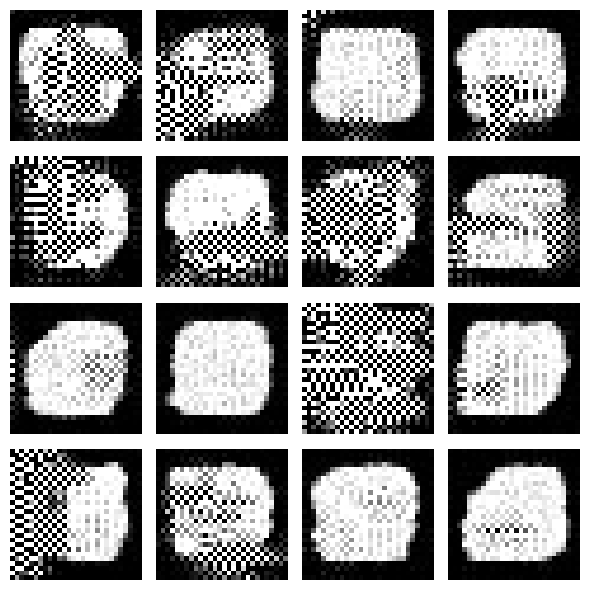

Generating samples for 2


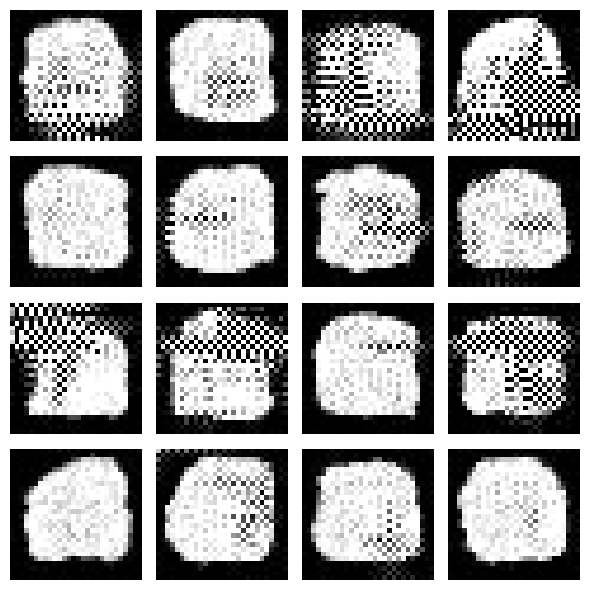

Generating samples for 3


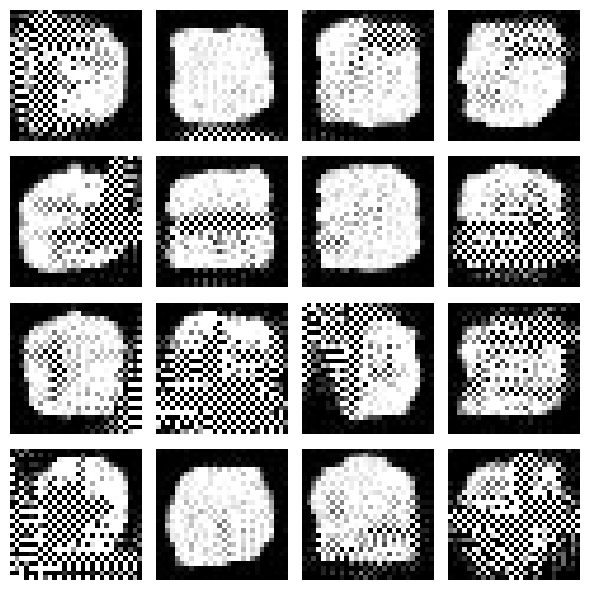

Generating samples for 4


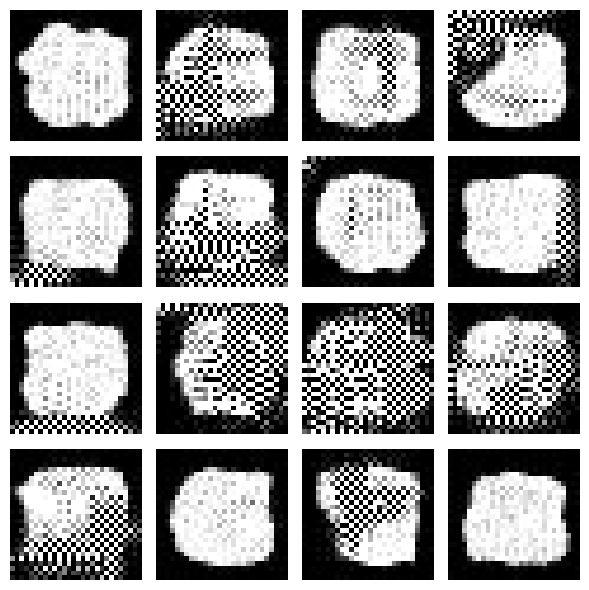

Generating samples for 5


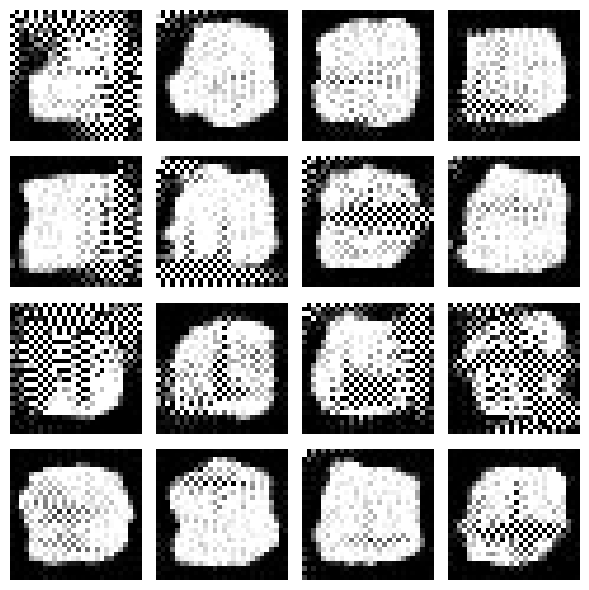

Generating samples for 6


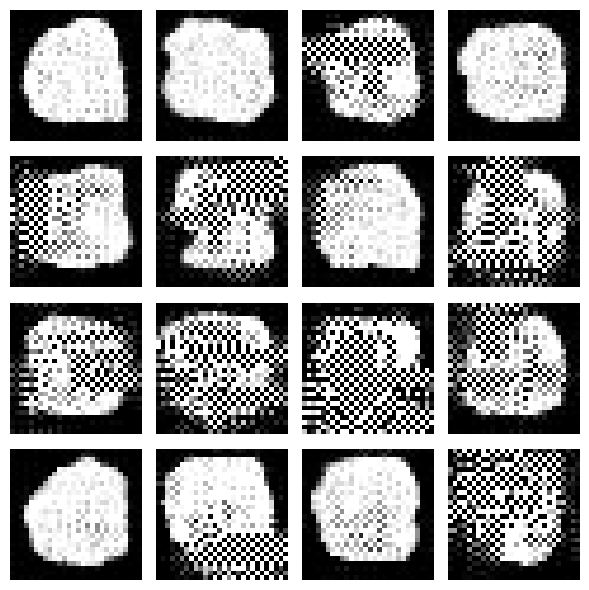

Generating samples for 7


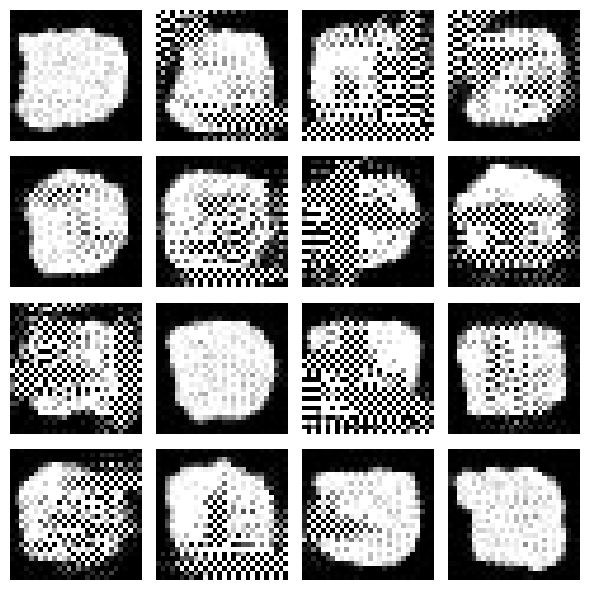

Generating samples for 8


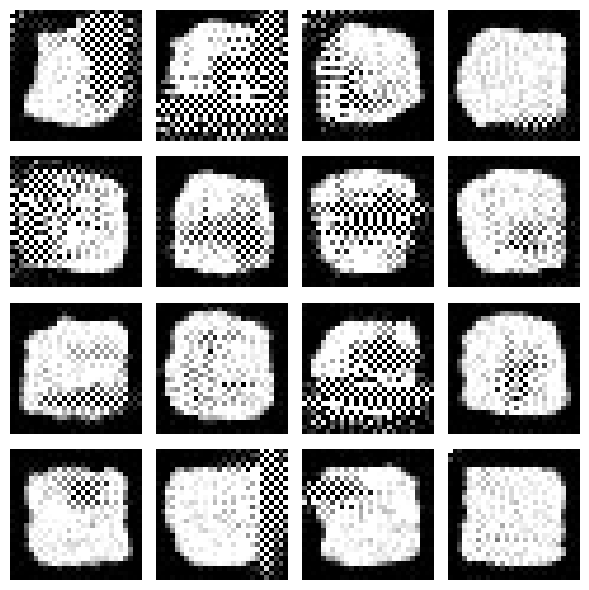

Generating samples for 9


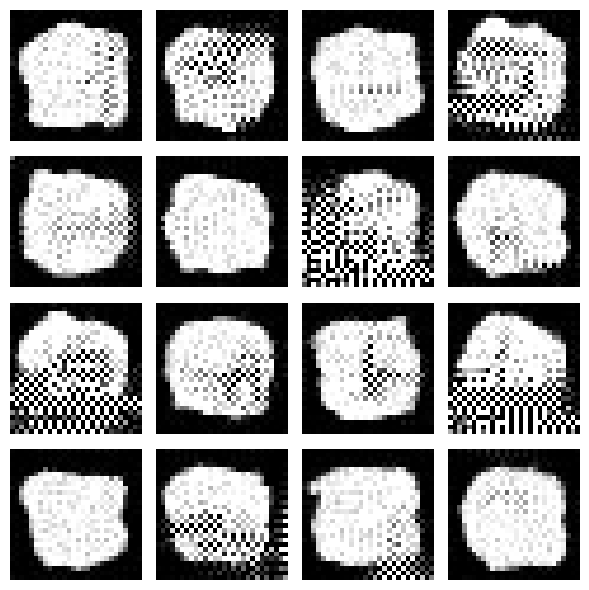

In [69]:

for num_to_gen in range (1,10):
    print(f"Generating samples for {num_to_gen}")
    # Generate samples of digit "3"
    samples = sample_ddpm(model, n=16, label=num_to_gen).cpu().clamp(-1, 1)
    samples = (samples + 1) / 2  # convert back to [0, 1] for display
    
    # Plot
    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(samples[i*4 + j].squeeze(), cmap='gray')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


In [70]:
@torch.no_grad()
def debug_sample(model, n=4, label=3):
    x = torch.randn(n, 1, 28, 28).to(device)
    y = torch.full((n,), label, device=device)
    imgs = []

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device)
        pred_noise = model(x, t_tensor, y)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        z = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) + torch.sqrt(beta_t) * z
        if t % 20 == 0:
            imgs.append(x.clone().cpu())

    return imgs

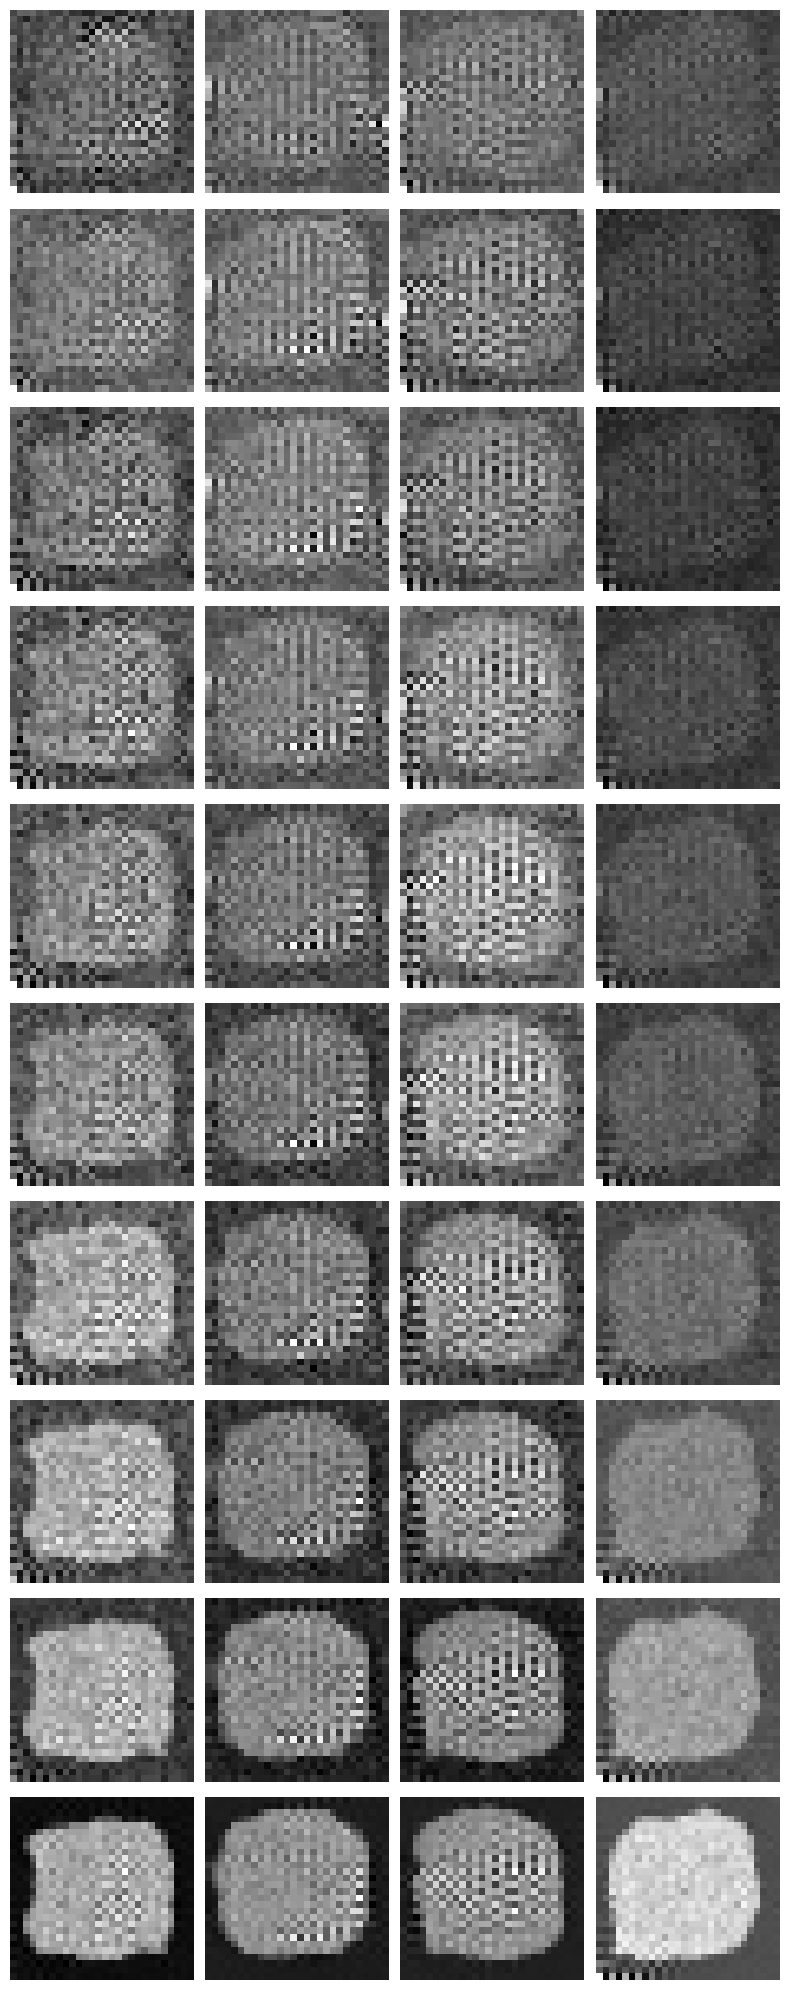

In [72]:
steps = debug_sample(model)
fig, axs = plt.subplots(len(steps), 4, figsize=(8, 2 * len(steps)))
for i, step in enumerate(steps):
    for j in range(4):
        axs[i, j].imshow(((step[j] + 1) / 2.0).squeeze(), cmap="gray")
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()